In [33]:
import os
import pandas as pd
import numpy as np
import requests
import json
import yfinance as yf
import seaborn as sns
from dotenv import load_dotenv
from openai import OpenAI
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


In [2]:
# Load .env file
load_dotenv()

True

In [3]:
# Check if the environment variable is set for Open AI API
api_key = os.getenv("OPENAI_API_KEY")
if api_key is None:
    raise ValueError("The environment variable 'OPENAI_API_KEY' is not set.")

In [4]:
# Check if the environment variable is set for Vantage API
van_api_key = os.getenv("VANTAGE_API_KEY")
if van_api_key is None:
    raise ValueError("The environment variable 'VANTAGE_API_KEY' is not set.")

In [5]:
# Stock symbol for S&P 500
symbol = "SPY"

# API URL for real-time stock data
stock_url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={van_api_key}"

# Fetch stock data
response = requests.get(stock_url)

stock_data = response.json()

print(stock_data)

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'SPY', '3. Last Refreshed': '2025-03-11', '4. Output Size': 'Compact', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2025-03-11': {'1. open': '559.4000', '2. high': '564.0200', '3. low': '552.0200', '4. close': '555.9200', '5. volume': '88102109'}, '2025-03-10': {'1. open': '567.5900', '2. high': '569.5400', '3. low': '555.5900', '4. close': '560.5800', '5. volume': '97084529'}, '2025-03-07': {'1. open': '570.9000', '2. high': '577.3900', '3. low': '565.6300', '4. close': '575.9200', '5. volume': '81158816'}, '2025-03-06': {'1. open': '575.4800', '2. high': '580.1736', '3. low': '570.1200', '4. close': '572.7100', '5. volume': '80094868'}, '2025-03-05': {'1. open': '576.6900', '2. high': '584.8800', '3. low': '573.0795', '4. close': '583.0600', '5. volume': '71230528'}, '2025-03-04': {'1. open': '579.7100', '2. high': '585.3900', '3. low': '572.2500', '4. close': '576.8600', '5.

In [6]:
# Extract time series data
time_series = stock_data["Time Series (Daily)"]
# Prints daily stock price data
print(time_series)

{'2025-03-11': {'1. open': '559.4000', '2. high': '564.0200', '3. low': '552.0200', '4. close': '555.9200', '5. volume': '88102109'}, '2025-03-10': {'1. open': '567.5900', '2. high': '569.5400', '3. low': '555.5900', '4. close': '560.5800', '5. volume': '97084529'}, '2025-03-07': {'1. open': '570.9000', '2. high': '577.3900', '3. low': '565.6300', '4. close': '575.9200', '5. volume': '81158816'}, '2025-03-06': {'1. open': '575.4800', '2. high': '580.1736', '3. low': '570.1200', '4. close': '572.7100', '5. volume': '80094868'}, '2025-03-05': {'1. open': '576.6900', '2. high': '584.8800', '3. low': '573.0795', '4. close': '583.0600', '5. volume': '71230528'}, '2025-03-04': {'1. open': '579.7100', '2. high': '585.3900', '3. low': '572.2500', '4. close': '576.8600', '5. volume': '109648212'}, '2025-03-03': {'1. open': '596.1800', '2. high': '597.3400', '3. low': '579.9000', '4. close': '583.7700', '5. volume': '74249199'}, '2025-02-28': {'1. open': '585.5600', '2. high': '594.7200', '3. lo

In [7]:
# Convert to DataFrame
df = pd.DataFrame.from_dict(time_series, orient="index")
df

,1. open,2. high,3. low,4. close,5. volume
2025-03-11,559.4000,564.0200,552.0200,555.9200,88102109
2025-03-10,567.5900,569.5400,555.5900,560.5800,97084529
2025-03-07,570.9000,577.3900,565.6300,575.9200,81158816
2025-03-06,575.4800,580.1736,570.1200,572.7100,80094868
2025-03-05,576.6900,584.8800,573.0795,583.0600,71230528
...,...,...,...,...,...
2024-10-21,583.8500,584.8500,580.6001,583.6300,36439010
2024-10-18,584.0700,585.3900,582.5800,584.5900,37416801
2024-10-17,585.9100,586.1200,582.1600,582.3500,34393714
2024-10-16,579.7800,582.8300,578.9600,582.3000,30725436


In [8]:
# Rename columns for readability
df.columns = ["open", "high", "low", "close", "volume"]
df

,open,high,low,close,volume
2025-03-11,559.4000,564.0200,552.0200,555.9200,88102109
2025-03-10,567.5900,569.5400,555.5900,560.5800,97084529
2025-03-07,570.9000,577.3900,565.6300,575.9200,81158816
2025-03-06,575.4800,580.1736,570.1200,572.7100,80094868
2025-03-05,576.6900,584.8800,573.0795,583.0600,71230528
...,...,...,...,...,...
2024-10-21,583.8500,584.8500,580.6001,583.6300,36439010
2024-10-18,584.0700,585.3900,582.5800,584.5900,37416801
2024-10-17,585.9100,586.1200,582.1600,582.3500,34393714
2024-10-16,579.7800,582.8300,578.9600,582.3000,30725436


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 2025-03-11 to 2024-10-15
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   open    100 non-null    object
 1   high    100 non-null    object
 2   low     100 non-null    object
 3   close   100 non-null    object
 4   volume  100 non-null    object
dtypes: object(5)
memory usage: 4.7+ KB


In [10]:
# Convert data types
df = df.astype(float)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 2025-03-11 to 2024-10-15
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    100 non-null    float64
 1   high    100 non-null    float64
 2   low     100 non-null    float64
 3   close   100 non-null    float64
 4   volume  100 non-null    float64
dtypes: float64(5)
memory usage: 4.7+ KB


In [12]:
# Reset index to make the date a column
df = df.reset_index()

In [13]:
# Rename the new column to "date" (if it’s not automatically named)
df = df.rename(columns={"index": "date"})
df

,date,open,high,low,close,volume
0,2025-03-11,559.40,564.0200,552.0200,555.92,88102109.0
1,2025-03-10,567.59,569.5400,555.5900,560.58,97084529.0
2,2025-03-07,570.90,577.3900,565.6300,575.92,81158816.0
3,2025-03-06,575.48,580.1736,570.1200,572.71,80094868.0
4,2025-03-05,576.69,584.8800,573.0795,583.06,71230528.0
...,...,...,...,...,...,...
95,2024-10-21,583.85,584.8500,580.6001,583.63,36439010.0
96,2024-10-18,584.07,585.3900,582.5800,584.59,37416801.0
97,2024-10-17,585.91,586.1200,582.1600,582.35,34393714.0
98,2024-10-16,579.78,582.8300,578.9600,582.30,30725436.0


In [14]:
# Convert to datetime format (recommended)
df["date"] = pd.to_datetime(df["date"])

# Display the DataFrame
df

,date,open,high,low,close,volume
0,2025-03-11,559.40,564.0200,552.0200,555.92,88102109.0
1,2025-03-10,567.59,569.5400,555.5900,560.58,97084529.0
2,2025-03-07,570.90,577.3900,565.6300,575.92,81158816.0
3,2025-03-06,575.48,580.1736,570.1200,572.71,80094868.0
4,2025-03-05,576.69,584.8800,573.0795,583.06,71230528.0
...,...,...,...,...,...,...
95,2024-10-21,583.85,584.8500,580.6001,583.63,36439010.0
96,2024-10-18,584.07,585.3900,582.5800,584.59,37416801.0
97,2024-10-17,585.91,586.1200,582.1600,582.35,34393714.0
98,2024-10-16,579.78,582.8300,578.9600,582.30,30725436.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    100 non-null    datetime64[ns]
 1   open    100 non-null    float64       
 2   high    100 non-null    float64       
 3   low     100 non-null    float64       
 4   close   100 non-null    float64       
 5   volume  100 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 4.8 KB


In [16]:
df.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [17]:
df.describe()

,date,open,high,low,close,volume
count,100,100.000000,100.000000,100.000000,100.000000,1.000000e+02
mean,2024-12-26 11:31:12,593.806050,596.321160,590.261268,593.384200,4.963831e+07
min,2024-10-15 00:00:00,559.400000,564.020000,552.020000,555.920000,2.604871e+07
25%,2024-11-18 18:00:00,585.347500,588.647500,580.832525,584.385000,3.630544e+07
50%,2024-12-25 00:00:00,596.225000,598.625000,592.252800,595.185000,4.406425e+07
75%,2025-02-03 06:00:00,603.780000,605.402475,600.216250,603.427500,5.719845e+07
max,2025-03-11 00:00:00,611.540000,613.230000,609.560000,612.930000,1.257167e+08
std,NaN,11.552832,10.973975,12.381275,11.944464,1.965777e+07


In [18]:
# Correlation between the variable
corr_matrix = df[['open', 'high', 'low', 'close', 'volume']].corr()
corr_matrix

,open,high,low,close,volume
open,1.000000,0.979865,0.962193,0.931813,-0.385519
high,0.979865,1.000000,0.962214,0.960682,-0.319989
low,0.962193,0.962214,1.000000,0.980973,-0.518799
close,0.931813,0.960682,0.980973,1.000000,-0.470844
volume,-0.385519,-0.319989,-0.518799,-0.470844,1.000000


<Axes: >

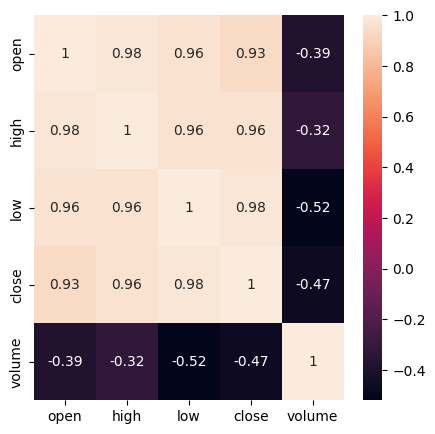

In [19]:
# Visualize the correlation matrix
plt.figure(figsize=(5,5))
sns.heatmap(corr_matrix, annot=True)

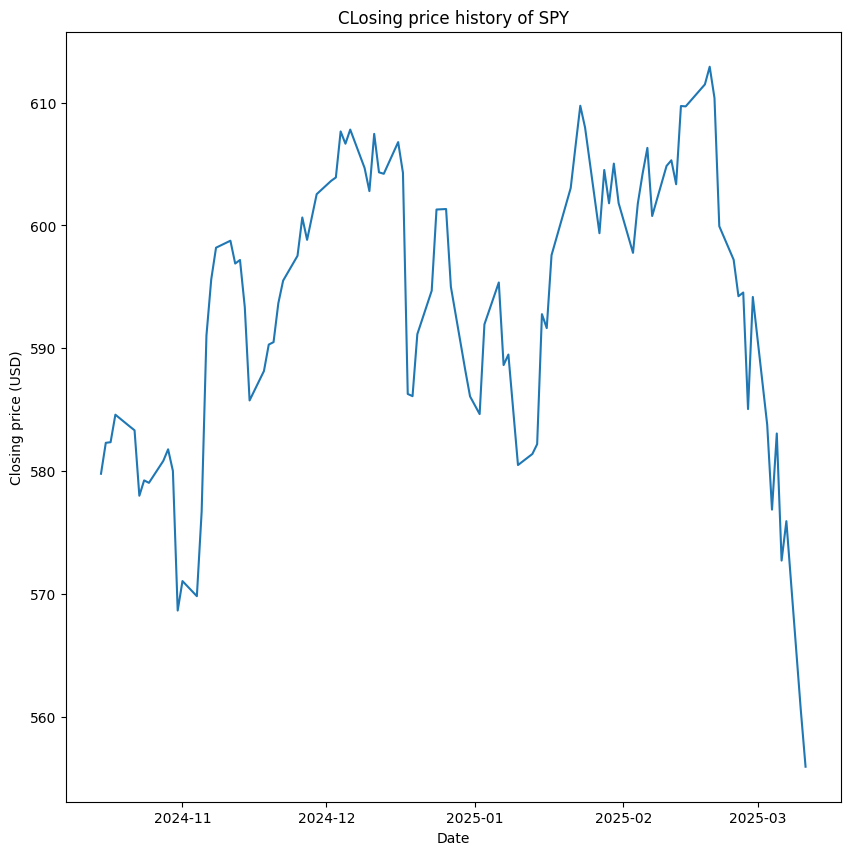

In [20]:
# Visualization of the closing price and the date
plt.figure(figsize=(10,10))
plt.title('CLosing price history of SPY')
plt.plot(df['date'], df['close'])
plt.xlabel('Date')
plt.ylabel('Closing price (USD)')
plt.show()

In [21]:
df.head()

,date,open,high,low,close,volume
0,2025-03-11,559.40,564.0200,552.0200,555.92,88102109.0
1,2025-03-10,567.59,569.5400,555.5900,560.58,97084529.0
2,2025-03-07,570.90,577.3900,565.6300,575.92,81158816.0
3,2025-03-06,575.48,580.1736,570.1200,572.71,80094868.0
4,2025-03-05,576.69,584.8800,573.0795,583.06,71230528.0


In [ ]:
# Build the machine learning algorithm
X = df[['open', 'high', 'low', 'volume']].values
y = df['close'].values

In [ ]:
# Data spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [24]:
X_train

array([[6.04190000e+02, 6.05170000e+02, 6.02885000e+02, 5.57735450e+07],
       [5.81290000e+02, 5.83320000e+02, 5.79290000e+02, 4.14358390e+07],
       [6.07500000e+02, 6.09960000e+02, 6.01050000e+02, 6.66714710e+07],
       [5.97420000e+02, 5.97750000e+02, 5.86780000e+02, 6.03930520e+07],
       [5.98800000e+02, 6.01330000e+02, 5.98070000e+02, 4.56212880e+07],
       [6.10880000e+02, 6.11490000e+02, 6.08380000e+02, 2.67490300e+07],
       [5.85880000e+02, 5.85950000e+02, 5.78550000e+02, 7.31050460e+07],
       [5.84070000e+02, 5.85390000e+02, 5.82580000e+02, 3.74168010e+07],
       [5.95930000e+02, 5.99580000e+02, 5.91855600e+02, 4.33215780e+07],
       [5.93400000e+02, 5.95120000e+02, 5.87450000e+02, 4.67502850e+07],
       [6.02020000e+02, 6.03030000e+02, 5.96490000e+02, 5.07372130e+07],
       [5.87890000e+02, 5.91740000e+02, 5.84410000e+02, 5.65787570e+07],
       [5.71180000e+02, 5.72500000e+02, 5.67890000e+02, 3.82169750e+07],
       [6.03720000e+02, 6.04130000e+02, 5.99220000e

In [25]:
# Feature scaling
# Standard scaler - mean of 0 and a standard deviation of 1
# Minmaxscaler 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [37]:
# Multi linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [27]:
# Prediction on the test set
y_pred_mlr = lin_reg.predict(X_test)

In [28]:
# Put in a dataframe
pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_mlr})

,Actual value,Predicted value
0,591.04,588.155576
1,586.10,587.347074
2,597.53,597.374513
3,584.64,583.923060
4,591.95,591.829620
5,581.39,581.350737
6,606.32,603.871170
7,598.76,598.066992
8,594.24,591.389304
9,555.92,557.178921


In [36]:
# model evaluation 
# r2, mean absolute error, mean square error, root mean square error
# 0, 1
# mae must have a lower mae 0. 
# mse --o.
# rmse 0. 
r2 = metrics.r2_score(y_test, y_pred_mlr)
meanABerr = metrics.mean_absolute_error(y_test, y_pred_mlr)
meanSqErr = metrics.mean_squared_error(y_test, y_pred_mlr)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlr))
print('R2:',r2)
print('Mean Absolute Error:',meanABerr)
print('Mean Square Error:',meanSqErr)
print('Root Mean Square Error:',rootMeanSqErr)

R2: 0.9803286283927367
Mean Absolute Error: 1.2215959736638524
Mean Square Error: 2.7031161730140942
Root Mean Square Error: 1.6441156203303022


In [38]:
# Support vector regression
# Radial basis function
svr = SVR(kernel = 'linear')
svr.fit(X_train, y_train)

SVR(kernel='linear')

In [39]:
# Prediction on the test data
y_pred_svr = svr.predict(X_test)

In [40]:
# Put in a dataframe
pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_svr})

,Actual value,Predicted value
0,591.04,588.102456
1,586.10,588.025452
2,597.53,598.228852
3,584.64,585.674314
4,591.95,590.384005
5,581.39,579.269995
6,606.32,604.905519
7,598.76,598.982459
8,594.24,593.173780
9,555.92,557.043242


In [41]:
r2 = metrics.r2_score(y_test, y_pred_svr)
meanABerr = metrics.mean_absolute_error(y_test, y_pred_svr)
meanSqErr = metrics.mean_squared_error(y_test, y_pred_svr)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_svr))
print('R2:',r2)
print('Mean Absolute Error:',meanABerr)
print('Mean Square Error:',meanSqErr)
print('Root Mean Square Error:',rootMeanSqErr)

R2: 0.9703721708335556
Mean Absolute Error: 1.710568645679024
Mean Square Error: 4.0712699546351745
Root Mean Square Error: 2.017738822205484
